# Setup

In [ ]:
import os
import random
import shutil
import zipfile
from io import BytesIO
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    Input,
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Dropout,
    Flatten
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2


# Dataset Setup

Dataset Information
The dataset used in this project is the ForestFireDataset, which can be accessed from [Mendeley Data](https://data.mendeley.com/datasets/fcsjwd9gr6/1). This dataset is provided under the Creative Commons Attribution 4.0 International (CC BY 4.0) license, which allows for both personal and commercial use, as long as appropriate credit is given to the original creators.

The dataset contains data related to forest fires, which includes various meteorological and environmental factors. It is typically used for tasks such as predicting the likelihood of forest fires based on these factors.

License
The CC BY 4.0 license allows you to:

* Share: Copy and redistribute the material in any medium, format, or platform.
* Adapt: Remix, transform, and build upon the material for any purpose, even commercially, under the following conditions:
* Attribution: You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
For more information on the full license, visit the official [Creative Commons website](https://creativecommons.org/licenses/by/4.0/).

## Problem Definition


* Objective: The goal of this project is to build a computer vision model capable of classifying images of forests as either containing a fire or not containing a fire. By automating the detection of forest fires from images, this model aims to assist in early fire detection and forest monitoring, providing valuable support to authorities in forest management and emergency response.

* Hypotheses and Assumptions:
The primary assumption is that the visual differences between images with fires and those without fires are sufficient for a model to learn and generalize the distinction. It is assumed that environmental factors such as vegetation type, weather conditions, and time of day have an impact on the visibility of fire and smoke in images.

* Dataset Description:
The dataset, ForestFireDataset using the classification data, includes 2974 images that depict different scenarios of forests with and without fires. These images are annotated with labels indicating whether the forest depicted in the image is on fire or not.

## Dataset Download

This code does the download and the unzip of the dataset using the requests library. This method makes it easier to download the data directly in the notebook without the need to connect to a cloud drive or upload manually every execution.

In [ ]:
%%capture
url = 'https://data.mendeley.com/public-files/datasets/fcsjwd9gr6/files/fedb4c31-3866-416e-b30d-ff18e8d965e9/file_downloaded'
# Send a GET request to download the file
response = requests.get(url)

# Ensure the request was successful
if response.status_code == 200:
    print("Download started successfully...")

    # Create a temporary in-memory file from the downloaded content
    zip_file = BytesIO(response.content)

    # Open the zip file
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # List all files in the zip file
        zip_ref.printdir()

        # Extract the 'ForestFireDataset' folder into the current working directory
        zip_ref.extractall('ForestFireDataset')

    print("Extraction complete. The 'ForestFireDataset' folder has been extracted.")
else:
    print(f"Failed to download the file. HTTP status code: {response.status_code}")

## Train-Test Split

This code does the train test split. If the split is already made, the images are restarted in the initial folder and reshuffled. Due to enouth training data (over 2k images) there is no need to do cross validation witch is really good because cross validation mixes training data with test data and the test results are less realiabe.

In [ ]:
def train_test_split(dataset_dir, test_size=0.2):
    # Validate test_size
    if not (0 < test_size < 1):
        raise ValueError("test_size must be between 0 and 1.")

    # Define paths for the train and test sets
    train_dir = os.path.join(dataset_dir, 'train')  # Folder with 'train' data
    fire_train_dir = os.path.join(train_dir, 'fire')  # Folder with 'fire' class
    nofire_train_dir = os.path.join(train_dir, 'nofire')  # Folder with 'nofire' class
    test_dir = os.path.join(dataset_dir, 'test')  # Folder for test data

    # Check if test directory exists; if not, create it
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
        os.makedirs(os.path.join(test_dir, 'fire'))
        os.makedirs(os.path.join(test_dir, 'nofire'))

    # Function to move images to the test folder
    def move_images_to_test(source_folder, target_folder):
        for filename in os.listdir(source_folder):
            source_path = os.path.join(source_folder, filename)
            target_path = os.path.join(target_folder, filename)
            if os.path.isfile(source_path):
                shutil.move(source_path, target_path)

    # Move any existing test images to the start of the test folder to reshuffle
    move_images_to_test(os.path.join(test_dir, 'fire'), fire_train_dir)
    move_images_to_test(os.path.join(test_dir, 'nofire'), nofire_train_dir)

    # Get the list of all images in both 'fire' and 'nofire' folders
    fire_images = [os.path.join(fire_train_dir, img) for img in os.listdir(fire_train_dir) if os.path.isfile(os.path.join(fire_train_dir, img))]
    nofire_images = [os.path.join(nofire_train_dir, img) for img in os.listdir(nofire_train_dir) if os.path.isfile(os.path.join(nofire_train_dir, img))]

    # Shuffle the images
    random.shuffle(fire_images)
    random.shuffle(nofire_images)

    # Calculate the split index
    fire_test_count = int(len(fire_images) * test_size)
    nofire_test_count = int(len(nofire_images) * test_size)

    # Move the selected images to the test folder
    for img in fire_images[:fire_test_count]:
        shutil.move(img, os.path.join(test_dir, 'fire', os.path.basename(img)))
    for img in nofire_images[:nofire_test_count]:
        shutil.move(img, os.path.join(test_dir, 'nofire', os.path.basename(img)))

    print(f"Train-test split complete. Test set contains {fire_test_count} fire images and {nofire_test_count} nofire images.")
    print(f"Training set contains {len(fire_images)} fire images and {len(nofire_images)} nofire images.")


In [ ]:
dataset_dir = 'ForestFireDataset/ForestFireDataset'
train_test_split(dataset_dir, test_size=0.2)  # 80% train, 20% test

Train-test split complete. Test set contains 334 fire images and 255 nofire images.
Training set contains 1672 fire images and 1275 nofire images.


Good news! The dataset contains a good number of images and is fairly balanced, which provides a solid foundation for training and evaluating the model effectively.

## Tensorflow Dataset Generator

This creates the generator responsible for generating and preparing images for each batch fed into the neural network. Data augmentation can be applied in the training generator, which generates new images by applying various transformations to the original ones. This process effectively increases the size of the training dataset, helping the model generalize better by exposing it to a broader range of image variations.

In [ ]:
# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,

    horizontal_flip=True,
    fill_mode='nearest'

)

# No data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    'ForestFireDataset/ForestFireDataset/train',
    target_size=(224, 224),  # Adjust target size as need
    batch_size=32,
    class_mode='binary'  # Assuming binary classification (fire vs. no fire)
)

test_generator = test_datagen.flow_from_directory(
    'ForestFireDataset/ForestFireDataset/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 2358 images belonging to 2 classes.
Found 589 images belonging to 2 classes.


# Models

## From Scratch

In [ ]:
input_shape = (224, 224, 3)
num_classes = 1

# Input Layer
inputs = Input(shape=input_shape)

# First Convolutional Block
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Second Convolutional Block
x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

# Third Convolutional Block
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.35)(x)

# Fourth Convolutional Block
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.35)(x)

# Flatten and Dense Layers
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(num_classes, activation='sigmoid')(x)

# Create Model
model = Model(inputs=inputs, outputs=outputs)

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.AUC(curve='PR')
        ]
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'from_scratch.keras',
    monitor='val_binary_accuracy',
    save_best_only=True
)

# Training history
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - auc: 0.8921 - auc_1: 0.8785 - binary_accuracy: 0.8232 - loss: 2.2161 - precision: 0.8002 - recall: 0.8084 - val_auc: 0.8284 - val_auc_1: 0.8220 - val_binary_accuracy: 0.5671 - val_loss: 2.8751 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 83s 888ms/step - auc: 0.9355 - auc_1: 0.9267 - binary_accuracy: 0.8702 - loss: 1.9233 - precision: 0.8478 - recall: 0.8502 - val_auc: 0.8919 - val_auc_1: 0.9017 - val_binary_accuracy: 0.5671 - val_loss: 2.7337 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 71s 896ms/step - auc: 0.9449 - auc_1: 0.9395 - binary_accuracy: 0.8841 - loss: 1.8346 - precision: 0.8838 - recall: 0.8467 - val_auc: 0.9169 - val_auc_1: 0.9213 - val_binary_accuracy: 0.5280 - val_loss: 2.5505 - val_precision: 0.4780 - val_recall: 0.9804
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 86s 927ms/step - auc: 0.9478 - auc_1: 0.9448 - binary_accuracy: 0.8844 - loss

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(len(history.history['binary_accuracy'])))
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(history.history['loss'])))
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('training_metrics_from_scratch.png')
plt.close()

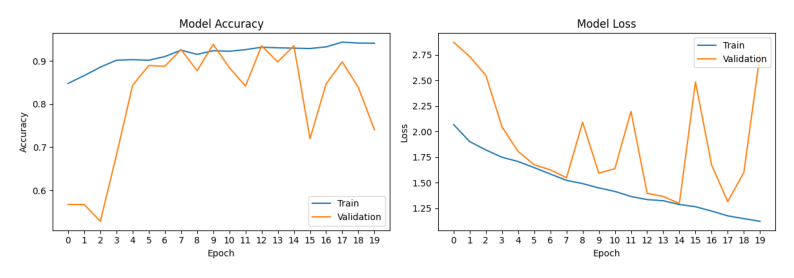

In [ ]:
plt.figure(figsize=(10, 8))
img = mpimg.imread('training_metrics_from_scratch.png')
plt.imshow(img)
plt.axis('off')
plt.show()

This result is highly promising. By implementing early stopping and the model checkpoint callback, we successfully saved the best-performing model across all epochs, avoiding overtraining. The model achieved a peak validation accuracy of approximately 94%. However, the training process revealed some challenges. While the training loss and accuracy consistently improved with each epoch, the validation loss and accuracy fluctuated, indicating potential overfitting. This suggests that the model might struggle to generalize effectively when trained solely on the available training data. Despite this issue, the validation accuracy remains strong, showcasing the model's overall effectiveness.

## Transfer Learning

In image classification tasks, transfer learning can be effectively utilized to leverage the capabilities of pre-trained networks. These networks, trained on large datasets, possess powerful feature extraction abilities. By removing their top layers and integrating a new classifier tailored to the specific problem, we can adapt their learned features to solve our unique task more efficiently, reducing both training time and the need for large amounts of labeled data.

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model layers.
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# Output layer for binary classification
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.AUC(curve='PR')
        ]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Model Summary

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,618,945 (9.99 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'transfer_learning.keras',
    monitor='val_binary_accuracy',
    save_best_only=True
)

# Training history
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 90s 984ms/step - auc_2: 0.7834 - auc_3: 0.6832 - binary_accuracy: 0.6992 - loss: 0.5578 - precision_1: 0.6652 - recall_1: 0.6143 - val_auc_2: 0.9739 - val_auc_3: 0.9744 - val_binary_accuracy: 0.8778 - val_loss: 0.3078 - val_precision_1: 1.0000 - val_recall_1: 0.7176
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 122s 797ms/step - auc_2: 0.9706 - auc_3: 0.9640 - binary_accuracy: 0.9182 - loss: 0.2209 - precision_1: 0.9188 - recall_1: 0.8811 - val_auc_2: 0.9883 - val_auc_3: 0.9875 - val_binary_accuracy: 0.9406 - val_loss: 0.1749 - val_precision_1: 0.9825 - val_recall_1: 0.8784
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 81s 801ms/step - auc_2: 0.9903 - auc_3: 0.9888 - binary_accuracy: 0.9532 - loss: 0.1378 - precision_1: 0.9562 - recall_1: 0.9355 - val_auc_2: 0.9913 - val_auc_3: 0.9904 - val_binary_accuracy: 0.9389 - val_loss: 0.1547 - val_precision_1: 0.9867 - val_recall_1: 0.8706
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 64s 785ms/step - auc_2: 0.9943 - auc_3: 0.

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(len(history.history['binary_accuracy'])))  # Set x-ticks to integer values
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(history.history['loss'])))  # Set x-ticks to integer values
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('training_metrics_transfer_learning.png')
plt.close()

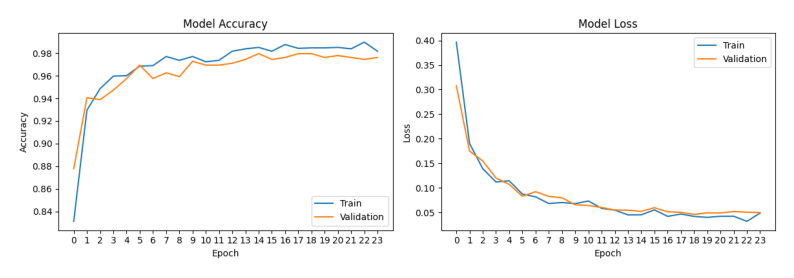

In [ ]:
plt.figure(figsize=(10, 8))  # Adjust the width and height in inches
img = mpimg.imread('training_metrics_transfer_learning.png')
plt.imshow(img)
plt.axis('off')  # Optional: Removes axes for cleaner display
plt.show()

This training yielded significantly improved results. Although the validation accuracy increased only slightly to 97.5%, the overall training process was much better. The validation and training loss remained closely aligned throughout, indicating that overfitting was effectively avoided. Furthermore, by employing an architecture designed for mobile applications, the model's storage size was significantly reduced, enhancing its portability across systems and enabling faster predictions.

## Fine Tunning

In the initial step of transfer learning, we froze the base model layers to allow the model to focus on predicting classes using the image patterns extracted by these pre-trained layers. After training the top layers, we proceed to unfreeze the entire model to fine-tune the base layers. This step aims to optimize the feature extraction process specifically for our dataset, potentially yielding improved results.

In [ ]:
model.trainable = True

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fine_tunning.keras',
    monitor='val_binary_accuracy',
    save_best_only=True
)

# Training history
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 65s 785ms/step - auc_2: 0.9981 - auc_3: 0.9973 - binary_accuracy: 0.9777 - loss: 0.0553 - precision_1: 0.9693 - recall_1: 0.9789 - val_auc_2: 0.9988 - val_auc_3: 0.9985 - val_binary_accuracy: 0.9762 - val_loss: 0.0500 - val_precision_1: 0.9839 - val_recall_1: 0.9608
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 84s 859ms/step - auc_2: 0.9991 - auc_3: 0.9989 - binary_accuracy: 0.9870 - loss: 0.0376 - precision_1: 0.9895 - recall_1: 0.9797 - val_auc_2: 0.9987 - val_auc_3: 0.9983 - val_binary_accuracy: 0.9779 - val_loss: 0.0481 - val_precision_1: 0.9690 - val_recall_1: 0.9804
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 63s 803ms/step - auc_2: 0.9996 - auc_3: 0.9995 - binary_accuracy: 0.9878 - loss: 0.0298 - precision_1: 0.9859 - recall_1: 0.9863 - val_auc_2: 0.9986 - val_auc_3: 0.9982 - val_binary_accuracy: 0.9762 - val_loss: 0.0500 - val_precision_1: 0.9839 - val_recall_1: 0.9608
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 63s 774ms/step - auc_2: 0.9986 - auc_3: 0.9

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(len(history.history['binary_accuracy'])))  # Set x-ticks to integer values
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(history.history['loss'])))  # Set x-ticks to integer values
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('training_metrics_fine_tunning.png')
plt.close()

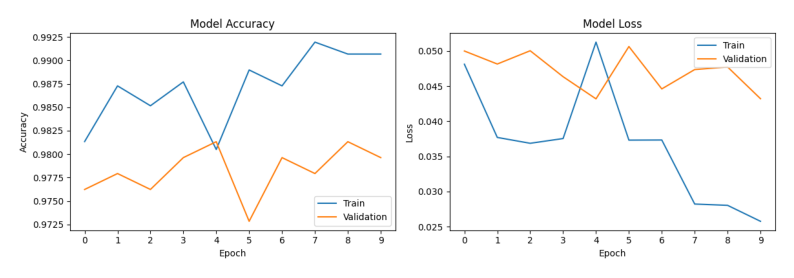

In [ ]:
plt.figure(figsize=(10, 8))  # Adjust the width and height in inches
img = mpimg.imread('training_metrics_fine_tunning.png')
plt.imshow(img)
plt.axis('off')  # Optional: Removes axes for cleaner display
plt.show()

The training progression might seem vary unstable at first, but it is important to look at the scale of the changes. The training continued to improve a bit, going up to 98.13% accuracy.

# Evaluation

To visualize and perform a final evaluation, let's review a selection of images along with their true labels and the predictions made by our model. This will help us assess how well the model performs.

In [ ]:
def visualize_predictions(model, test_generator, num_rows=2, num_cols=5):
    num_samples = num_rows * num_cols
    x_batch, y_batch = next(test_generator)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

    axes = axes.flatten() if num_rows > 1 else axes

    for i in range(num_samples):
        image = x_batch[i]
        true_label = y_batch[i]
        prediction = model.predict(np.expand_dims(image, axis=0))

        axes[i].imshow(image)

        if round(prediction[0][0]) == 0:
            prediction = 'Fire'
        else:
            prediction = 'No Fire'

        if round(true_label) == 0:
            true_label = 'Fire'
        else:
            true_label = 'No Fire'

        axes[i].set_title(f'True: {true_label}\nPred: {prediction}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
model = load_model('fine_tunning.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


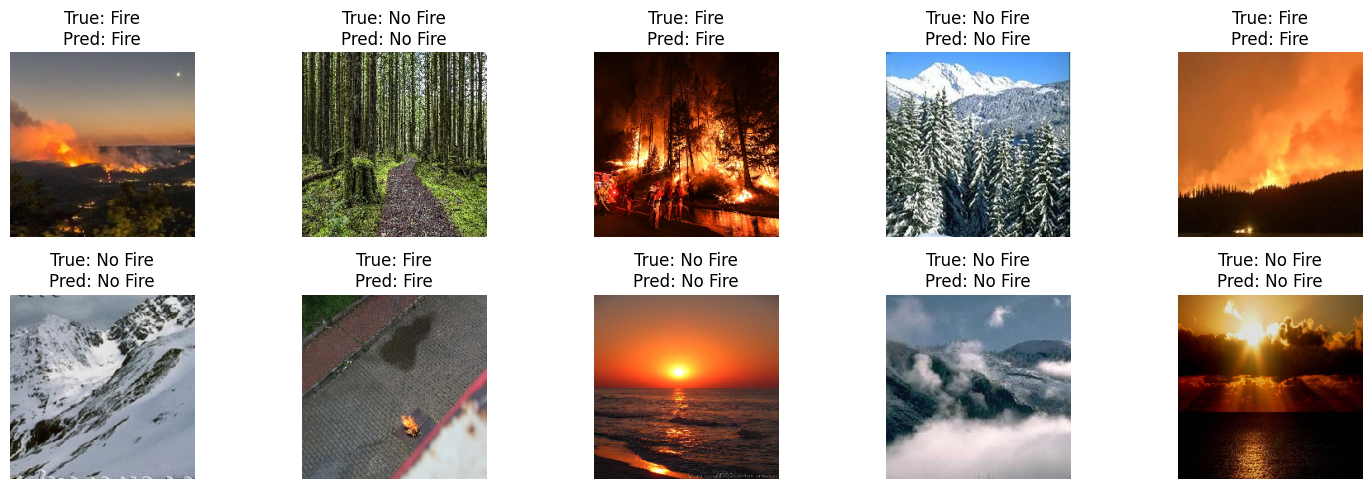

In [ ]:
visualize_predictions(model, test_generator)

Given the high accuracy of our model, it correctly classified all images. However, we can observe potential areas for confusion. For instance, images featuring the sun, which share similar bright orange and red hues, could have been misclassified as fires due to the similarity in color patterns.

In [ ]:
def full_model_evaluation(model, test_generator):
    # Compile model with comprehensive metrics
    model.compile(
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.AUC(curve='PR')  # Precision-Recall AUC
        ]
    )

    # Evaluate model with confusion matrix callback
    evaluation_results = model.evaluate(test_generator)

    # Prepare metrics dictionary
    metrics = {
        'loss': evaluation_results[0],
        'binary_accuracy': evaluation_results[1],
        'precision': evaluation_results[2],
        'recall': evaluation_results[3],
        'auc': evaluation_results[4],
        'pr_auc': evaluation_results[5]
    }

    return metrics

In [ ]:
metrics = full_model_evaluation(model, test_generator)

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 433ms/step - auc_4: 0.9990 - auc_5: 0.9986 - binary_accuracy: 0.9851 - loss: 0.0433 - precision_2: 0.9746 - recall_2: 0.9906


In [ ]:
metrics

{'loss': 0.04318756237626076,
 'binary_accuracy': 0.9813242554664612,
 'precision': 0.9728682041168213,
 'recall': 0.9843137264251709,
 'auc': 0.9989433288574219,
 'pr_auc': 0.9986225366592407}

Our binary image classifier model has shown excellent performance across several important metrics. Here is a detailed evaluation of each metric:

* Loss (0.0432)

    The loss value represents the difference between the model's predictions and the actual labels. A lower loss indicates better performance, and in this case, a loss of 0.0432 is quite low, reflecting that the model is making accurate predictions with minimal error.

* Binary Accuracy (0.9813):

    Binary accuracy measures the percentage of correct predictions for the binary classification task. With an accuracy of 98.13%, the model is correctly predicting the class in the vast majority of cases, indicating its effectiveness in distinguishing between the two classes.

* Precision (0.9729):

    Precision calculates the proportion of positive predictions that are actually correct. A precision of 97.29% means that when the model predicts a positive class, it is highly likely to be correct. This suggests that the model is excellent at identifying true positives without many false positives.

* Recall (0.9843):

    Recall measures the proportion of actual positives that the model correctly identifies. A recall of 98.43% indicates that the model is highly effective at identifying most of the true positive instances, minimizing false negatives.

* AUC (0.9989):

    The Area Under the Receiver Operating Characteristic Curve (AUC) is a measure of the model's ability to discriminate between the two classes. An AUC of 0.9989 is extremely high, suggesting that the model can effectively distinguish between the positive and negative classes across all decision thresholds.

* PR AUC (0.9986):

    The Precision-Recall AUC (PR AUC) provides insight into the model’s performance, especially when dealing with imbalanced classes. A PR AUC of 0.9986 reflects that the model has excellent precision and recall, even when considering the balance between the classes.

# Conclusion

The developed convolutional neural network demonstrates promising results in accurately detecting forest fires from image data. The model, trained on the ForestFireDataset, effectively distinguishes between images containing fires and those without. By incorporating data augmentation techniques, regularization strategies, and a comprehensive set of evaluation metrics, the model achieves robust performance. The project provides a valuable foundation for further exploration in the field of computer vision-based forest fire detection, with potential applications in early warning systems and remote sensing.